## lab 1 

In [35]:
import pandas as pd
import numpy as np
import json

from googleapiclient import discovery
from googleapiclient import errors

import time 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import RandomizedSearchCV

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

import plotly.graph_objects as go
import plotly.express as px


import os

## upload data in GCS

In [265]:
REGION = 'us-central1'
ARTIFACT_STORE = 'gs://benazirsproject-demo'

PROJECT_ID = !(gcloud config get-value core/project)
PROJECT_ID = PROJECT_ID[0]
DATA_ROOT='{}/data'.format(ARTIFACT_STORE)
JOB_DIR_ROOT='{}/jobs'.format(ARTIFACT_STORE)
TRAINING_FILE_PATH='{}/{}/{}'.format(DATA_ROOT, 'training', 'Anonymized_Fermentation_Data_final.xlsx')
# VALIDATION_FILE_PATH='{}/{}/{}'.format(DATA_ROOT, 'validation', 'dataset.csv')
TESTING_FILE_PATH='{}/{}/{}'.format(DATA_ROOT, 'testing', 'test_amyris.csv')

In [266]:
TESTING_FILE_PATH 

'gs://benazirsproject-demo/data/testing/test_amyris.csv'

In [37]:
data = pd.read_excel(TRAINING_FILE_PATH,sheet_name='data')
meta_data = pd.read_excel(TRAINING_FILE_PATH, sheet_name='meta data')

## they need to upload data in bigquery - and then 

In [40]:
%%bigquery
SELECT *
FROM `amyris.amyris_fermentation_data`

,Product,Purpose,experiment,run,Project_Name,run_label,Strain,strain_key,Feedstock_Parent1,Start_Time,...,Cap_Oil_Em_End__percent,Cap_PCV_End__percent,Cap_Dead_Cell_Layer_End__percent,Zeex9ieJAlt_end__g_L,Zeex9ieJ_mAU_sec_end__area,Zeex9ieJ_Screening_end__g_L,Zeex9ieJ_end__g_L,Zeex9ieJ_end__g_L_121,Zeex9ieJ_end__g_L_122,interval_type
0,Zeex9ieJ,MF,F9FD5EC4C1,15,Zeex9ieJ for All,11408-15,F9FD5EC4C1,9215897,m1098919,1/20/21 2:25 PM,...,16.32145,21.04034,NULL,7.455144,1.3341,9.923562,0.606429,0.675183,0,Cumulative
1,Zeex9ieJ,MF,F9FD5EC4C1,15,Zeex9ieJ for All,11408-15,F9FD5EC4C1,9215897,m1098919,1/20/21 2:25 PM,...,16.32145,21.04034,NULL,7.455144,1.3341,9.923562,0.606429,0.675183,0,Curated
2,Zeex9ieJ,MF,F9FD5EC4C1,15,Zeex9ieJ for All,11408-15,F9FD5EC4C1,9215897,m1098919,1/20/21 2:25 PM,...,16.32145,21.04034,NULL,7.455144,1.3341,9.923562,0.606429,0.675183,0,Cumulative (Day 3-)
3,Zeex9ieJ,MF,F9FD5EC4C1,15,Zeex9ieJ for All,11408-15,F9FD5EC4C1,9215897,m1098919,1/20/21 2:25 PM,...,16.32145,21.04034,NULL,7.455144,1.3341,9.923562,0.606429,0.675183,0,Single
4,Zeex9ieJ,MF,F9FD5EC4C1,16,Zeex9ieJ for All,11409-16,F9FD5EC4C1,9215897,m1098919,1/20/21 2:24 PM,...,15.21805,20.34157,NULL,4.546885,2.179946,7.52725,0.342935,0.455659,1.684056,Cumulative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1563,Zeex9ieJ,MF,B4EDDA67F0,8,Zeex9ieJ for All,16209-8,B4EDDA67F0,8770794,m1252714,9/30/21 2:32 PM,...,19.50613,22.02205,NULL,17.845346,0,0,0,0,NULL,Single
1564,Zeex9ieJ,MF,B4EDDA67F0,8,Zeex9ieJ for All,16209-8,B4EDDA67F0,8770794,m1252714,9/30/21 2:32 PM,...,16.0144,18.78522,NULL,31.702724,0,0,0,0,NULL,Cumulative (Day 3-)
1565,Zeex9ieJ,MF,B4EDDA67F0,8,Zeex9ieJ for All,16209-8,B4EDDA67F0,8770794,m1252714,9/30/21 2:32 PM,...,16.5879,18.74606,NULL,38.355477,0,0,0,0,NULL,Cumulative (Day 3-)
1566,Zeex9ieJ,MF,B4EDDA67F0,8,Zeex9ieJ for All,16209-8,B4EDDA67F0,8770794,m1252714,9/30/21 2:32 PM,...,16.0144,18.78522,NULL,31.702724,0,0,0,0,NULL,Single


In [43]:
!bq query \
-n 0 \
--destination_table amyris.training \
--replace \
--use_legacy_sql=false \
'SELECT * \
FROM `amyris.amyris_fermentation_data` AS training \
WHERE \
MOD(ABS(FARM_FINGERPRINT(TO_JSON_STRING(training))), 10) IN (1, 2, 3, 4)' 

Waiting on bqjob_r7286b0f3cf393f52_000001744bd1a546_1 ... (1s) Current status: DONE   


In [38]:
meta_data.head()

print('The data contains {} samples and {} variables'.format(data.shape[0],data.shape[1]))
print('There are {} unique strains which are replicated or measured under different fermentation conditions.'.format(data['Strain'].nunique()))
print('The variables are comprised of a variety of fermentation process (meta data), physiological and biochemical parameters (independent):')
display(meta_data['variable type'].value_counts())
print('include: {}'.format(meta_data.query('target == 1').name.values))

The data contains 1568 samples and 124 variables
There are 20 unique strains which are replicated or measured under different fermentation conditions.
The variables are comprised of a variety of fermentation process (meta data), physiological and biochemical parameters (independent):


independent    63
metadata       53
dependent       5
category        3
Name: variable type, dtype: int64

include: ['Run_Execution' 'Run_Performance' 'Product_Produced__g'
 'Titer_End__g_over_kg']


In [78]:
#prepare data for analysis
#split out numeric from categorical varibles
numeric_vars = ((data.dtypes == 'float64') | (data.dtypes == 'int64')) & (meta_data['variable type'] == 'independent').values
numeric_x_data = data[data.columns[numeric_vars]]

#things to try to predict
model_target = 'Run_Performance'
y_data = data[[model_target]] 
#data[data.columns[(meta_data['target'] == 1).values]]
y_data.head()

,Run_Performance
0,delta
1,delta
2,delta
3,delta
4,delta


In [40]:
#meta data about variables
meta_data = meta_data.set_index('name')

In [24]:
# X_train = numeric_x_data[:1400]
# y_train = y_data[:1400]
# X_validate = numeric_x_data[1400:]
# y_validate = y_data[1400:]

In [250]:

#maintain class balance
X_train, X_test, y_train, y_test = train_test_split(numeric_x_data, y_data, test_size=0.25, stratify = y_data[model_target], random_state=42)

#split train set to create a pseudo test or validation dataset
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size=0.33, stratify= y_train[model_target], random_state=42)

In [258]:
# Xy_test = pd.concat([X_test, y_test])
Xy_test =X_test.join(y_test)
Xy_test.head()


,Viable_Cell_Density__g_over_L,Product_Flux_Viable_Cells__mmol_over_gDCW_over_h,Growth_Rate_Viable_Cells__1_over_h,Death_Rate_Avg__1_over_h,Death_Rate_Avg_Viable_Cells__1_over_h,TRS_Flux_Viable_Cells__mmol_over_gDCW_over_h,TRS_Flux__mmol_over_gDCW_over_h,TRS_for_Other_Viable_Cells__mmol_over_gDCW_over_h,sOUR_Viable_Cells__mmol_over_gDCW_over_h,TRS_to_Maintenance_Flux__mmol_over_gDCW_over_h,...,Cap_Feedstock_Solids_End__percent,Cap_Heavy_Em_End__percent,Cap_Light_Em_End__percent,Cap_Oil_Em_End__percent,Cap_PCV_End__percent,Cap_Dead_Cell_Layer_End__percent,Zeex9ieJAlt_end__g_L,Zeex9ieJ_mAU_sec_end__area,Zeex9ieJ_Screening_end__g_L,Run_Performance
1344,NaN,NaN,NaN,NaN,NaN,NaN,1.022618,NaN,NaN,0.580472,...,NaN,0.59890,0.00000,31.23719,14.02679,NaN,4.279656,711.209220,10.704900,delta
100,42.640952,0.019322,0.011842,0.002537,0.003682,0.721315,0.497036,0.486782,2.087218,0.335427,...,NaN,0.21529,1.63002,17.48424,21.26711,NaN,12.811126,1.287626,15.784800,gamma
1206,NaN,NaN,NaN,NaN,NaN,NaN,1.693218,NaN,NaN,0.955499,...,NaN,0.64506,12.48656,16.15727,19.72047,NaN,12.304696,1430.264616,20.768533,delta
1004,NaN,NaN,NaN,NaN,NaN,NaN,0.980806,NaN,NaN,0.690178,...,NaN,0.48696,3.48728,27.08137,11.37292,NaN,15.430124,NaN,9.538637,delta
847,NaN,NaN,NaN,NaN,NaN,NaN,1.861936,NaN,NaN,1.072883,...,NaN,1.98190,2.04432,19.19476,20.20911,NaN,19.018522,NaN,24.216795,delta


In [263]:
Xy_test.to_csv('test_amyris.csv', index=False)
new_df = pd.read_csv('test_amyris.csv')
new_df.head()

,Viable_Cell_Density__g_over_L,Product_Flux_Viable_Cells__mmol_over_gDCW_over_h,Growth_Rate_Viable_Cells__1_over_h,Death_Rate_Avg__1_over_h,Death_Rate_Avg_Viable_Cells__1_over_h,TRS_Flux_Viable_Cells__mmol_over_gDCW_over_h,TRS_Flux__mmol_over_gDCW_over_h,TRS_for_Other_Viable_Cells__mmol_over_gDCW_over_h,sOUR_Viable_Cells__mmol_over_gDCW_over_h,TRS_to_Maintenance_Flux__mmol_over_gDCW_over_h,...,Cap_Feedstock_Solids_End__percent,Cap_Heavy_Em_End__percent,Cap_Light_Em_End__percent,Cap_Oil_Em_End__percent,Cap_PCV_End__percent,Cap_Dead_Cell_Layer_End__percent,Zeex9ieJAlt_end__g_L,Zeex9ieJ_mAU_sec_end__area,Zeex9ieJ_Screening_end__g_L,Run_Performance
0,NaN,NaN,NaN,NaN,NaN,NaN,1.022618,NaN,NaN,0.580472,...,NaN,0.59890,0.00000,31.23719,14.02679,NaN,4.279656,711.209220,10.704900,delta
1,42.640952,0.019322,0.011842,0.002537,0.003682,0.721315,0.497036,0.486782,2.087218,0.335427,...,NaN,0.21529,1.63002,17.48424,21.26711,NaN,12.811126,1.287626,15.784800,gamma
2,NaN,NaN,NaN,NaN,NaN,NaN,1.693218,NaN,NaN,0.955499,...,NaN,0.64506,12.48656,16.15727,19.72047,NaN,12.304696,1430.264616,20.768533,delta
3,NaN,NaN,NaN,NaN,NaN,NaN,0.980806,NaN,NaN,0.690178,...,NaN,0.48696,3.48728,27.08137,11.37292,NaN,15.430124,NaN,9.538637,delta
4,NaN,NaN,NaN,NaN,NaN,NaN,1.861936,NaN,NaN,1.072883,...,NaN,1.98190,2.04432,19.19476,20.20911,NaN,19.018522,NaN,24.216795,delta


In [42]:
#impute missing with median
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
#auto scale
scaler = StandardScaler()

pipe = Pipeline([('imputer',imputer),
                 ('scaler', scaler)
                ])

In [43]:
#prepare data for modeling
#use the pipeline created above

_X_train = pipe.fit_transform(X_train)
_y_train = y_train[model_target]
_X_test = pipe.fit_transform(X_validate)
_y_test = y_validate[model_target]

In [44]:


# Simple hyperparameter tunnig for random forest model
estimator = RandomForestClassifier(random_state = 42)

# tune grid
param_grid = {
    'n_estimators': np.linspace(10, 200).astype(int),
    'max_depth': [None] + list(np.linspace(3, 20).astype(int)),
    'max_features': ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1)),
    'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False],
    'class_weight' : ["balanced", "balanced_subsample"] # RF classifier tends to be biased towards the majority class, place a heavier penalty on misclassifying the minority class
}

print('class weights (1,0): {}'.format(compute_class_weight('balanced', np.unique(_y_train), _y_train)) )



# Create the random search model
rs = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
                        scoring = 'roc_auc', cv = 3, 
                        n_iter = 10, verbose = 1, random_state=42)

# Fit 
rs.fit(_X_train, _y_train)
pca_result = pipe.fit(X_train, y_train.values.ravel())


class weights (1,0): [0.74105461 1.53710938]
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=['delta' 'gamma'], y=957     delta
1203    delta
1218    delta
574     gamma
232     delta
        ...  
492     gamma
1491    delta
1501    delta
1180    delta
1336    delta
Name: Run_Performance, Length: 787, dtype: object as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   14.2s finished


In [64]:
_X_train = pipe.fit_transform(X_train)
_y_train = y_train[model_target]
_X_test = pipe.fit_transform(X_validate)
_y_test = y_validate[model_target]

# Simple hyperparameter tunnig for random forest model
estimator = RandomForestClassifier(random_state = 42)

estimator.fit(_X_train, _y_train)

rf_predictions = estimator.predict(_X_test)
print('Accuracy of classifier on test set: {:.2f}'.format(estimator.score(_X_test, _y_test).round(2)))
print(classification_report(_y_test, rf_predictions))

Accuracy of classifier on test set: 0.95
              precision    recall  f1-score   support

       delta       0.97      0.95      0.96       262
       gamma       0.90      0.94      0.92       127

    accuracy                           0.95       389
   macro avg       0.94      0.95      0.94       389
weighted avg       0.95      0.95      0.95       389



In [45]:
#select best model
best_model = rs.best_estimator_

train_rf_predictions = best_model.predict(_X_train)
train_rf_probs = best_model.predict_proba(_X_train)[:, 1]

rf_predictions = best_model.predict(_X_test)
rf_probs = best_model.predict_proba(_X_test)[:, 1]

Accuracy of classifier on validation set: 0.86
              precision    recall  f1-score   support

       delta       0.97      0.81      0.88       262
       gamma       0.71      0.94      0.81       127

    accuracy                           0.86       389
   macro avg       0.84      0.88      0.85       389
weighted avg       0.88      0.86      0.86       389



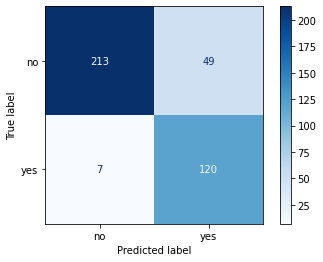

In [46]:
#evaluate performance on validation data


print('Accuracy of classifier on validation set: {:.2f}'.format(best_model.score(_X_test, _y_test).round(2)))
print(classification_report(_y_test, rf_predictions))
plot_confusion_matrix(best_model, _X_test, _y_test,
                                 display_labels=['no','yes'],
                                 cmap=plt.cm.Blues)

## steps to create an image

In [308]:
TRAIN_IMAGE_FOLDER = 'train_image'
os.makedirs(TRAIN_IMAGE_FOLDER, exist_ok=True)

In [340]:
%%writefile {TRAIN_IMAGE_FOLDER}/train.py

# Copyright 2019 Google Inc. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#            http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import os
import subprocess
import sys

import fire
import pickle
import numpy as np
import pandas as pd
import json

import hypertune

from sklearn.compose import ColumnTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from googleapiclient import discovery
from googleapiclient import errors


def train_evaluate(job_dir, training_dataset_path, n_estimators, max_leaf_nodes, max_depth, min_samples_split, max_features, 
                   class_weight, bootstrap, hptune):
    data = pd.read_excel(trainin g_dataset_path,sheet_name='data')
    meta_data = pd.read_excel(training_dataset_path, sheet_name='meta data')
    
    numeric_vars = ((data.dtypes == 'float64') | (data.dtypes == 'int64')) & (meta_data['variable type'] == 'independent').values
    numeric_x_data = data[data.columns[numeric_vars]]

    model_target = 'Run_Performance'
    y_data = data[[model_target]] 
    meta_data = meta_data.set_index('name')
 

    #maintain class balance
    X_train, X_test, y_train, y_test = train_test_split(numeric_x_data, y_data, test_size=0.25, stratify = y_data[model_target], random_state=42)

    #split train set to create a pseudo test or validation dataset
    X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size=0.33, stratify= y_train[model_target], random_state=42)
    
    if not hptune:
        X_train = pd.concat([X_train, X_validate])
        y_train = pd.concat([y_train, y_validate])

    #impute missing with median
    imputer = SimpleImputer(missing_values=np.nan, strategy='median')
    #auto scale
    scaler = StandardScaler()
    
     # Simple hyperparameter tunnig for random forest model
    estimator = RandomForestClassifier(random_state = 42)
    
     
    pipe = Pipeline([('imputer',imputer),
                     ('scaler', scaler),
                     ('rfclassifier', estimator)
                    ])
    
    
    pipe.set_params(rfclassifier__n_estimators=n_estimators, rfclassifier__max_leaf_nodes=max_leaf_nodes, rfclassifier__max_depth=max_depth,
                       rfclassifier__min_samples_split=min_samples_split, rfclassifier__max_features=max_features, 
                       rfclassifier__class_weight=class_weight, rfclassifier__bootstrap=bootstrap )
    pipe.fit(X_train, y_train)

    
#     _X_train = pipe.fit_transform(X_train)
#     _y_train = y_train[model_target]
#     _X_test = pipe.fit_transform(X_test)
#     _y_test = y_test[model_target]
    
      
#     estimator.fit(_X_train, _y_train) 
#     rf_predictions = estimator.predict(_X_test)
#     print('Accuracy of classifier on test set: {:.2f}'.format(estimator.score(_X_test, _y_test).round(2)))
#     print(classification_report(_y_test, rf_predictions))
       
        
####################################3 
#         # tune grid
#     param_grid = {
#         'n_estimators': np.linspace(10, 200).astype(int),
#         'max_depth': [None] + list(np.linspace(3, 20).astype(int)),
#         'max_features': ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1)),
#         'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
#         'min_samples_split': [2, 5, 10],
#         'bootstrap': [True, False],
#         'class_weight' : ["balanced", "balanced_subsample"] # RF classifier tends to be biased towards the majority class, place a heavier penalty on misclassifying the minority class
#     }

#     print('class weights (1,0): {}'.format(compute_class_weight('balanced', np.unique(_y_train), _y_train)) )

#     # Create the random search model
#     rs = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
#                             scoring = 'roc_auc', cv = 3, 
#                             n_iter = 10, verbose = 1, random_state=42)

#     # Fit 
#     rs.fit(_X_train, _y_train)

#     #select best model
#     best_model = rs.best_estimator_

#     train_rf_predictions = best_model.predict(_X_train)
#     train_rf_probs = best_model.predict_proba(_X_train)[:, 1]

#     rf_predictions = best_model.predict(_X_test)
#     rf_probs = best_model.predict_proba(_X_test)[:, 1]
# #     evaluate performance on validation data
#     print('Accuracy of classifier on validation set: {:.2f}'.format(best_model.score(_X_test, _y_test).round(2)))
#     print(classification_report(_y_test, rf_predictions))

#########################################################3

    if hptune:
#         _X_validate = pipe.fit_transform(X_validate)
#         _y_validate = y_validate[model_target]
        accuracy = pipe.score(X_validate, y_validate)
        print('Model accuracy: {}'.format(accuracy))
        # Log it with hypertune
        hpt = hypertune.HyperTune()
        hpt.report_hyperparameter_tuning_metric(
          hyperparameter_metric_tag='accuracy',
          metric_value=accuracy
        )

    # Save the model
    if not hptune:
        model_filename = 'model.pkl'
        with open(model_filename, 'wb') as model_file:
            pickle.dump(pipe, model_file)
        gcs_model_path = "{}/{}".format(job_dir, model_filename)
        subprocess.check_call(['gsutil', 'cp', model_filename, gcs_model_path], stderr=sys.stdout)
        print("Saved model in: {}".format(gcs_model_path)) 
    
if __name__ == "__main__":
    fire.Fire(train_evaluate)

Overwriting train_image/train.py


In [341]:
%%writefile {TRAIN_IMAGE_FOLDER}/hptuning_config.yaml

# Copyright 2019 Google Inc. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#            http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

trainingInput:
  hyperparameters:
    goal: MAXIMIZE
    maxTrials: 4
    maxParallelTrials: 4
    hyperparameterMetricTag: accuracy
    enableTrialEarlyStopping: TRUE 
    algorithm: RANDOM_SEARCH
    params:
    - parameterName: n_estimators
      type: INTEGER
      minValue:  10
      maxValue:  200
      scaleType: UNIT_LINEAR_SCALE
    - parameterName: max_leaf_nodes
      type: INTEGER
      minValue:  10
      maxValue:  500
      scaleType: UNIT_LINEAR_SCALE    
    - parameterName: max_depth
      type: INTEGER
      minValue:  3
      maxValue:  20
      scaleType: UNIT_LINEAR_SCALE
    - parameterName: min_samples_split
      type: DISCRETE
      discreteValues: [
          2,
          5,
          10
          ]
    - parameterName: max_features
      type: DOUBLE
      minValue: 0.5
      maxValue: 1.0
      scaleType: UNIT_LINEAR_SCALE
    - parameterName: class_weight
      type: CATEGORICAL
      categoricalValues: [
          "balanced",
          "balanced_subsample"
      ]
    - parameterName: bootstrap
      type: CATEGORICAL
      categoricalValues: [
          "TRUE",
          "FALSE"
      ]
        

Overwriting train_image/hptuning_config.yaml


## package script into a docker image 

In [311]:
%%writefile {TRAIN_IMAGE_FOLDER}/Dockerfile

FROM gcr.io/deeplearning-platform-release/base-cpu
RUN pip install -U fire cloudml-hypertune scikit-learn==0.20.4 pandas==0.24.2
WORKDIR /app
COPY train.py .

ENTRYPOINT ["python", "train.py"]

Writing train_image/Dockerfile


# buidl the docker image 

In [312]:
IMAGE_NAME='trainer_image'
IMAGE_TAG='latest'
TRAINER_IMAGE='gcr.io/{}/{}:{}'.format(PROJECT_ID, IMAGE_NAME, IMAGE_TAG)

In [313]:
!gcloud builds submit --tag $TRAINER_IMAGE $TRAIN_IMAGE_FOLDER

Creating temporary tarball archive of 3 file(s) totalling 7.6 KiB before compression.
Uploading tarball of [train_image] to [gs://benazirsproject_cloudbuild/source/1599349075.61-ff58cc9bfa0a4e57a151c321486e9e7f.tgz]
Created [https://cloudbuild.googleapis.com/v1/projects/benazirsproject/builds/009e8d35-05cc-4ad2-bd30-c7b2d28399ab].
Logs are available at [https://console.cloud.google.com/cloud-build/builds/009e8d35-05cc-4ad2-bd30-c7b2d28399ab?project=981930454113].
----------------------------- REMOTE BUILD OUTPUT ------------------------------
starting build "009e8d35-05cc-4ad2-bd30-c7b2d28399ab"

FETCHSOURCE
Fetching storage object: gs://benazirsproject_cloudbuild/source/1599349075.61-ff58cc9bfa0a4e57a151c321486e9e7f.tgz#1599349076035661
Copying gs://benazirsproject_cloudbuild/source/1599349075.61-ff58cc9bfa0a4e57a151c321486e9e7f.tgz#1599349076035661...
/ [1 files][  2.8 KiB/  2.8 KiB]                                                
Operation completed over 1 objects/2.8 KiB.          

## create hyperparameter file 

## start hyper parameter tuning job 

In [125]:
JOB_NAME = "JOB_{}".format(time.strftime("%Y%m%d_%H%M%S"))
JOB_DIR = "{}/{}".format(JOB_DIR_ROOT, JOB_NAME)
SCALE_TIER = "BASIC"

!gcloud ai-platform jobs submit training $JOB_NAME \
--region=$REGION \
--job-dir=$JOB_DIR \
--master-image-uri=$TRAINER_IMAGE \
--scale-tier=$SCALE_TIER \
--config $TRAIN_IMAGE_FOLDER/hptuning_config.yaml \
-- \
--training_dataset_path=$TRAINING_FILE_PATH \
--hptune

Job [JOB_20200904_020441] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ai-platform jobs describe JOB_20200904_020441

or continue streaming the logs with the command

  $ gcloud ai-platform jobs stream-logs JOB_20200904_020441
jobId: JOB_20200904_020441
state: QUEUED


In [126]:
ml = discovery.build('ml', 'v1')

job_id = 'projects/{}/jobs/{}'.format(PROJECT_ID, JOB_NAME)
request = ml.projects().jobs().get(name=job_id)

try:
    response = request.execute()
except errors.HttpError as err:
    print(err)
except:
    print("Unexpected error")
    
response

{'jobId': 'JOB_20200904_020441',
 'trainingInput': {'args': ['--training_dataset_path=gs://benazirsproject-demo/data/training/Anonymized_Fermentation_Data_final.xlsx',
   '--hptune'],
  'hyperparameters': {'goal': 'MAXIMIZE',
   'params': [{'parameterName': 'n_estimators',
     'minValue': 10,
     'maxValue': 200,
     'type': 'INTEGER',
     'scaleType': 'UNIT_LINEAR_SCALE'},
    {'parameterName': 'max_depth',
     'minValue': 3,
     'maxValue': 20,
     'type': 'INTEGER',
     'scaleType': 'UNIT_LINEAR_SCALE'},
    {'parameterName': 'min_samples_split',
     'type': 'DISCRETE',
     'discreteValues': [2, 5, 10]}],
   'maxTrials': 4,
   'maxParallelTrials': 4,
   'hyperparameterMetricTag': 'accuracy',
   'enableTrialEarlyStopping': True,
   'algorithm': 'RANDOM_SEARCH'},
  'region': 'us-central1',
  'jobDir': 'gs://benazirsproject-demo/jobs/JOB_20200904_020441',
  'masterConfig': {'imageUri': 'gcr.io/benazirsproject/amyris_trainer_image2:latest'}},
 'createTime': '2020-09-04T02:04:4

In [217]:
response['trainingOutput']['trials'][0]

{'trialId': '2',
 'hyperparameters': {'n_estimators': '131',
  'min_samples_split': '2',
  'max_depth': '20'},
 'finalMetric': {'trainingStep': '1', 'objectiveValue': 0.9897172236503856},
 'startTime': '2020-09-04T02:05:21.684116167Z',
 'endTime': '2020-09-04T02:13:55Z',
 'state': 'SUCCEEDED'}

In [218]:
max_depth = response['trainingOutput']['trials'][0]['hyperparameters']['max_depth']
n_estimators = response['trainingOutput']['trials'][0]['hyperparameters']['n_estimators']
max_leaf_nodes = response['trainingOutput']['trials'][0]['hyperparameters']['max_leaf_nodes']
min_samples_split = response['trainingOutput']['trials'][0]['hyperparameters']['min_samples_split']
max_features = response['trainingOutput']['trials'][0]['hyperparameters']['max_features']
class_weight = response['trainingOutput']['trials'][0]['hyperparameters']['class_weight']
bootstrap = response['trainingOutput']['trials'][0]['hyperparameters']['bootstrap']
    

In [130]:
JOB_NAME = "JOB_{}".format(time.strftime("%Y%m%d_%H%M%S"))
JOB_DIR = "{}/{}".format(JOB_DIR_ROOT, JOB_NAME)
SCALE_TIER = "BASIC"

!gcloud ai-platform jobs submit training $JOB_NAME \
--region=$REGION \
--job-dir=$JOB_DIR \
--master-image-uri=$TRAINER_IMAGE \
--scale-tier=$SCALE_TIER \
-- \
--training_dataset_path=$TRAINING_FILE_PATH \
--max_depth=$max_depth \
--n_estimators=$n_estimators \
--max_leaf_nodes=$max_leaf_nodes \
--min_samples_split=$min_samples_split \
--max_features=$max_features \
--class_weight=$class_weight \
--bootstrap=$bootstrap \
--nohptune

Job [JOB_20200904_021933] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ai-platform jobs describe JOB_20200904_021933

or continue streaming the logs with the command

  $ gcloud ai-platform jobs stream-logs JOB_20200904_021933
jobId: JOB_20200904_021933
state: QUEUED


In [326]:
model_name = 'amyris_endtoendRF2mp'
labels = "task=classifier,domain=healthcare"
filter = 'name:{}'.format(model_name)
models = !(gcloud ai-platform models list --filter={filter} --format='value(name)')

if not models:
    !gcloud ai-platform models create  $model_name \
        --regions=$REGION \
        --labels=$labels
else:
    print("Model: {} already exists.".format(models[1]))

Model: amyris_endtoendRF2mp already exists.


In [325]:
model_version = 'v01'
filter = 'name:{}'.format(model_version)
versions = !(gcloud ai-platform versions list --model={model_name} --format='value(name)' --filter={filter})

if not versions:
    !gcloud ai-platform versions create {model_version} \
        --model={model_name} \
        --origin=$JOB_DIR \
        --runtime-version=1.15 \
        --framework=scikit-learn \
        --python-version=3.7
else:
    print("Model version: {} already exists.".format(versions[1]))

Model version: v01 already exists.


In [221]:
input_file = 'serving_instances.json'

with open(input_file, 'w') as f:
    for index, row in X_validate.head().iterrows():
        f.write(json.dumps(list(row.values)))
        f.write('\n')

In [222]:
!cat $input_file

[NaN, NaN, NaN, NaN, NaN, NaN, 0.945866, NaN, NaN, 0.494202588206387, NaN, NaN, NaN, 7.0, 7.0, 1.0, 0.00134783702916585, 41.71766, 61.90571, 0.67032, 202.69596, 306.98965, NaN, 306.98965, 202.69596, 0.01653, 0.00482, 0.0205689315250881, 120.0, 81.97552, NaN, 2.118, 1.14006, 1.32468, 0.48883, 3.78405, 0.0, 100000000.0, 29.893056975288, 6.8732723, 11.042327931, 48.539034072552, 1.161872929525, 0.0, 0.437723046051, 0.158397586631, 0.422029989697, 0.0, 0.377984030119, 0.193620639333, 0.900680499402, NaN, NaN, NaN, NaN, NaN, NaN, NaN, 8.997901, 1.412973, 9.294714]
[NaN, NaN, NaN, NaN, NaN, NaN, 0.650987, NaN, NaN, 0.488844046545112, 97.91514, 92.06308, 90.143693670312, 6.0, 6.0, 0.0, 0.00116329542495008, 4.41833, 7.90815, NaN, 38.14325, 50.46973, 3.80748, 50.46973, 38.14325, 0.00884, 0.00268, 0.0114366673210033, 120.0, 90.44944, 1.84214970527458, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, 1.8643, NaN, 1.72677, 0.0, 18.24572, 21.3478, 

In [223]:
!gcloud ai-platform predict \
--model $model_name \
--version $model_version \
--json-instances $input_file

Using endpoint [https://ml.googleapis.com/]
[u'delta', u'gamma', u'delta', u'delta', u'delta']


In [331]:
TRAINER_IMAGE

'gcr.io/benazirsproject/trainer_image:latest'

In [267]:
TESTING_FILE_PATH

'gs://benazirsproject-demo/data/testing/test_amyris.csv'

In [342]:
%%writefile ./pipeline/amyris_pipeline.py
# Copyright 2019 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
"""KFP pipeline orchestrating BigQuery and Cloud AI Platform services."""

import os

from helper_components import evaluate_model
from helper_components import retrieve_best_run
from jinja2 import Template
import kfp
from kfp.components import func_to_container_op
from kfp.dsl.types import Dict
from kfp.dsl.types import GCPProjectID
from kfp.dsl.types import GCPRegion
from kfp.dsl.types import GCSPath
from kfp.dsl.types import String
from kfp.gcp import use_gcp_secret

# Defaults and environment settings
BASE_IMAGE = os.getenv('BASE_IMAGE')
TRAINER_IMAGE = os.getenv('TRAINER_IMAGE')
RUNTIME_VERSION = os.getenv('RUNTIME_VERSION')
PYTHON_VERSION = os.getenv('PYTHON_VERSION')
COMPONENT_URL_SEARCH_PREFIX = os.getenv('COMPONENT_URL_SEARCH_PREFIX')
USE_KFP_SA = os.getenv('USE_KFP_SA')
TRAINING_FILE_PATH = 'gs://benazirsproject-demo/data/training/Anonymized_Fermentation_Data_final.xlsx'
TESTING_FILE_PATH = 'gs://benazirsproject-demo/data/testing/test_amyris.csv'
# VALIDATION_FILE_PATH = 'datasets/validation/data.csv'
# TESTING_FILE_PATH = 'datasets/testing/data.csv'

# Parameter defaults
# SPLITS_DATASET_ID = 'splits'
HYPERTUNE_SETTINGS = """
{
    "hyperparameters":  {
        "goal": "MAXIMIZE",
        "maxTrials": 3,
        "maxParallelTrials": 3,
        "hyperparameterMetricTag": "accuracy",
        "enableTrialEarlyStopping": True,
        "algorithm": "RANDOM_SEARCH",
        "params": [
            {
                "parameterName": "n_estimators",
                "type": "INTEGER",
                "minValue": 10,
                "maxValue": 200,
                "scaleType": "UNIT_LINEAR_SCALE"
            },
            {
                "parameterName": "max_leaf_nodes",
                "type": "INTEGER",
                "minValue": 10,
                "maxValue": 500,
                "scaleType": "UNIT_LINEAR_SCALE"
            },
            {
                "parameterName": "max_depth",
                "type": "INTEGER",
                "minValue": 3,
                "maxValue": 20,
                "scaleType": "UNIT_LINEAR_SCALE"
            },
            {
                "parameterName": "min_samples_split",
                "type": "DISCRETE",
                "discreteValues": [2,5,10]
            },
            {
                "parameterName": "max_features",
                "type": "DOUBLE",
                "minValue": 0.5,
                "maxValue": 1.0,
                "scaleType": "UNIT_LINEAR_SCALE"
            },
            {
                "parameterName": "class_weight",
                "type": "CATEGORICAL",
                "categoricalValues": [ "balanced", "balanced_subsample"]
            },
            {
                "parameterName": "bootstrap",
                "type": "CATEGORICAL",
                "categoricalValues": [ "TRUE", "FALSE"]
            }
        ]
    }
}
"""

# # Helper functions
# def generate_sampling_query(source_table_name, num_lots, lots):
#     """Prepares the data sampling query."""

#     sampling_query_template = """
#          SELECT *
#          FROM 
#              `{{ source_table }}` AS cover
#          WHERE 
#          MOD(ABS(FARM_FINGERPRINT(TO_JSON_STRING(cover))), {{ num_lots }}) IN ({{ lots }})
#          """
#     query = Template(sampling_query_template).render(
#         source_table=source_table_name, num_lots=num_lots, lots=str(lots)[1:-1])

#     return query


# Create component factories
component_store = kfp.components.ComponentStore(
    local_search_paths=None, url_search_prefixes=[COMPONENT_URL_SEARCH_PREFIX])

# bigquery_query_op = component_store.load_component('bigquery/query')
mlengine_train_op = component_store.load_component('ml_engine/train')
mlengine_deploy_op = component_store.load_component('ml_engine/deploy')
retrieve_best_run_op = func_to_container_op(
    retrieve_best_run, base_image=BASE_IMAGE)
evaluate_model_op = func_to_container_op(evaluate_model, base_image=BASE_IMAGE)


@kfp.dsl.pipeline(
    name='Amyris Classifier Training',
    description='The pipeline training and deploying the Amyris classifierpipeline_yaml'
)
def amyris_train(project_id,
                    region,
                    gcs_root,
                    evaluation_metric_name,
                    evaluation_metric_threshold,
                    model_id,
                    version_id,
                    replace_existing_version,
                    hypertune_settings=HYPERTUNE_SETTINGS,
                    dataset_location='US'):
    """Orchestrates training and deployment of an sklearn model."""

    # Create the training split
#     query = generate_sampling_query(
#         source_table_name=source_table_name, num_lots=10, lots=[1, 2, 3, 4])

#     training_file_path = '{}/{}'.format(gcs_root, TRAINING_FILE_PATH)

#     create_training_split = bigquery_query_op(
#         query=query,
#         project_id=project_id,
#         dataset_id=dataset_id,
#         table_id='',
#         output_gcs_path=training_file_path,
#         dataset_location=dataset_location)

#     # Create the validation split
#     query = generate_sampling_query(
#         source_table_name=source_table_name, num_lots=10, lots=[8])

#     validation_file_path = '{}/{}'.format(gcs_root, VALIDATION_FILE_PATH)

#     create_validation_split = bigquery_query_op(
#         query=query,
#         project_id=project_id,
#         dataset_id=dataset_id,
#         table_id='',
#         output_gcs_path=validation_file_path,
#         dataset_location=dataset_location)

    # Create the testing split
#     query = generate_sampling_query(
#         source_table_name=source_table_name, num_lots=10, lots=[9])

#     testing_file_path = '{}/{}'.format(gcs_root, TESTING_FILE_PATH)

#     create_testing_split = bigquery_query_op(
#         query=query,
#         project_id=project_id,
#         dataset_id=dataset_id,
#         table_id='',
#         output_gcs_path=testing_file_path,
#         dataset_location=dataset_location)

    # Tune hyperparameters
    tune_args = [
        '--training_dataset_path',
        TRAINING_FILE_PATH,
         '--hptune', 'True'
    ]

    job_dir = '{}/{}/{}'.format(gcs_root, 'jobdir/hypertune',
                                kfp.dsl.RUN_ID_PLACEHOLDER)

    hypertune = mlengine_train_op(
        project_id=project_id,
        region=region,
        master_image_uri=TRAINER_IMAGE,
        job_dir=job_dir,
        args=tune_args,
        training_input=hypertune_settings)

    # Retrieve the best trial
    get_best_trial = retrieve_best_run_op(
            project_id, hypertune.outputs['job_id'])

    # Train the model on a combined training and validation datasets
    job_dir = '{}/{}/{}'.format(gcs_root, 'jobdir', kfp.dsl.RUN_ID_PLACEHOLDER)

    train_args = [
        '--training_dataset_path',
       TRAINING_FILE_PATH,
        '--n_estimators',get_best_trial.outputs['n_estimators'], 
        '--max_leaf_nodes',get_best_trial.outputs['max_leaf_nodes'], 
        '--max_depth',get_best_trial.outputs['max_depth'],
        '--min_samples_split',get_best_trial.outputs['min_samples_split'],
        '--max_features',get_best_trial.outputs['max_features'],
        '--class_weight',get_best_trial.outputs['class_weight'],
        '--bootstrap',get_best_trial.outputs['bootstrap'],
        '--hptune', 'False'
    ]

    train_model = mlengine_train_op(
        project_id=project_id,
        region=region,
        master_image_uri=TRAINER_IMAGE,
        job_dir=job_dir,
        args=train_args)

    # Evaluate the model on the testing split
    eval_model = evaluate_model_op(
        dataset_path=TESTING_FILE_PATH,
        model_path=str(train_model.outputs['job_dir']),
        metric_name=evaluation_metric_name)

    # Deploy the model if the primary metric is better than threshold
    with kfp.dsl.Condition(eval_model.outputs['metric_value'] > evaluation_metric_threshold):
        deploy_model = mlengine_deploy_op(
        model_uri=train_model.outputs['job_dir'],
        project_id=project_id,
        model_id=model_id,
        version_id=version_id,
        runtime_version=RUNTIME_VERSION,
        python_version=PYTHON_VERSION,
        replace_existing_version=replace_existing_version)

    # Configure the pipeline to run using the service account defined
      # in the user-gcp-sa k8s secret
    if USE_KFP_SA == 'True':
        kfp.dsl.get_pipeline_conf().add_op_transformer(
              use_gcp_secret('user-gcp-sa'))

Overwriting ./pipeline/amyris_pipeline.py


In [172]:
TRAINER_IMAGE

'gcr.io/benazirsproject/amyris_trainer_image2:latest'

In [343]:
%%writefile ./pipeline/helper_components.py

# Copyright 2019 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
"""Helper components."""

from typing import NamedTuple


def retrieve_best_run(project_id: str, job_id: str) -> NamedTuple('Outputs', [('metric_value', float), ('n_estimators', int),
                            ('max_leaf_nodes', int), ('max_depth', int), ('min_samples_split', int),
                             ('max_features', float), ('class_weight', str), ('bootstrap', str)]):
    """Retrieves the parameters of the best Hypertune run."""

    from googleapiclient import discovery
    from googleapiclient import errors
    
    ml = discovery.build('ml', 'v1')

    job_name = 'projects/{}/jobs/{}'.format(project_id, job_id)
    request = ml.projects().jobs().get(name=job_name)

    try:
        response = request.execute()
    except errors.HttpError as err:
        print(err)
    except:
        print('Unexpected error')

    print(response)

    best_trial = response['trainingOutput']['trials'][0]

    metric_value = best_trial['finalMetric']['objectiveValue']

    n_estimators = int(best_trial['hyperparameters']['n_estimators'])
    max_leaf_nodes = int(best_trial['hyperparameters']['max_leaf_nodes'])
    max_depth = int(best_trial['hyperparameters']['max_depth'])
    min_samples_split = int(best_trial['hyperparameters']['min_samples_split'])
    max_features = float(best_trial['hyperparameters']['max_features'])
    class_weight = best_trial['hyperparameters']['class_weight']
    bootstrap = best_trial['hyperparameters']['bootstrap']

    return (metric_value, n_estimators, max_leaf_nodes, max_depth, min_samples_split, max_features, class_weight, bootstrap )


def evaluate_model(dataset_path: str, model_path: str, metric_name: str) -> NamedTuple('Outputs', [('metric_name', str), ('metric_value', float),
                            ('mlpipeline_metrics', 'Metrics')]):
    
    """Evaluates a trained sklearn model."""
    import pickle
    import json
    import pandas as pd
    import subprocess
    import sys

    from sklearn.metrics import accuracy_score, recall_score

    df_test = pd.read_csv(dataset_path)

    X_test = df_test.drop('Run_Performance', axis=1)
    y_test = df_test['Run_Performance']

    # Copy the model from GCS
    model_filename = 'model.pkl'
    gcs_model_filepath = '{}/{}'.format(model_path, model_filename)
    print(gcs_model_filepath)
    subprocess.check_call(['gsutil', 'cp', gcs_model_filepath, model_filename],
                        stderr=sys.stdout)

    with open(model_filename, 'rb') as model_file:
        model = pickle.load(model_file)
        
    y_hat = model.predict(X_test)

    if metric_name == 'accuracy':
        metric_value = accuracy_score(y_test, y_hat)
    elif metric_name == 'recall':
        metric_value = recall_score(y_test, y_hat)
    else:
        metric_name = 'N/A'
        metric_value = 0

    # Export the metric
    metrics = {
      'metrics': [{
          'name': metric_name,
          'numberValue': float(metric_value)
      }]
    }

    return (metric_name, metric_value, json.dumps(metrics))


Overwriting ./pipeline/helper_components.py


## create an empty folder base_image

In [271]:
%%writefile ./base_image/Dockerfile
FROM gcr.io/deeplearning-platform-release/base-cpu
RUN pip install -U fire scikit-learn==0.20.4 pandas==0.24.2 kfp==0.2.5

Overwriting ./base_image/Dockerfile


In [272]:
IMAGE_NAME='base_image'
TAG='latest'
BASE_IMAGE='gcr.io/{}/{}:{}'.format(PROJECT_ID, IMAGE_NAME, TAG)

In [273]:
!gcloud builds submit --timeout 15m --tag $BASE_IMAGE base_image

Creating temporary tarball archive of 1 file(s) totalling 122 bytes before compression.
Uploading tarball of [base_image] to [gs://benazirsproject_cloudbuild/source/1599228597.5-862becd638ab48cba856e4d9138fadcf.tgz]
Created [https://cloudbuild.googleapis.com/v1/projects/benazirsproject/builds/10f0594a-da4c-44f2-b174-c0694df81a7a].
Logs are available at [https://console.cloud.google.com/cloud-build/builds/10f0594a-da4c-44f2-b174-c0694df81a7a?project=981930454113].
----------------------------- REMOTE BUILD OUTPUT ------------------------------
starting build "10f0594a-da4c-44f2-b174-c0694df81a7a"

FETCHSOURCE
Fetching storage object: gs://benazirsproject_cloudbuild/source/1599228597.5-862becd638ab48cba856e4d9138fadcf.tgz#1599228597934229
Copying gs://benazirsproject_cloudbuild/source/1599228597.5-862becd638ab48cba856e4d9138fadcf.tgz#1599228597934229...
/ [1 files][  228.0 B/  228.0 B]                                                
Operation completed over 1 objects/228.0 B.            

In [274]:
REGION = 'us-central1'
ENDPOINT = '19a5aed0f754a516-dot-us-central2.pipelines.googleusercontent.com'
ARTIFACT_STORE_URI = 'gs://benazirsproject-demo'
PROJECT_ID = !(gcloud config get-value core/project)
PROJECT_ID = PROJECT_ID[0]

## compile pipeline 

In [275]:
USE_KFP_SA = False

COMPONENT_URL_SEARCH_PREFIX = 'https://raw.githubusercontent.com/kubeflow/pipelines/0.2.5/components/gcp/'
RUNTIME_VERSION = '1.15'
PYTHON_VERSION = '3.7'

%env USE_KFP_SA={USE_KFP_SA}
%env BASE_IMAGE={BASE_IMAGE}
%env TRAINER_IMAGE={TRAINER_IMAGE}
%env COMPONENT_URL_SEARCH_PREFIX={COMPONENT_URL_SEARCH_PREFIX}
%env RUNTIME_VERSION={RUNTIME_VERSION}
%env PYTHON_VERSION={PYTHON_VERSION}

env: USE_KFP_SA=False
env: BASE_IMAGE=gcr.io/benazirsproject/base_image:latest
env: TRAINER_IMAGE=gcr.io/benazirsproject/amyris_trainer_image2:latest
env: COMPONENT_URL_SEARCH_PREFIX=https://raw.githubusercontent.com/kubeflow/pipelines/0.2.5/components/gcp/
env: RUNTIME_VERSION=1.15
env: PYTHON_VERSION=3.7


## copy helper components 

In [276]:
!dsl-compile --py pipeline/amyris_pipeline.py --output amyris_pipeline.yaml 

In [202]:
!head amyris_pipeline.yaml 

apiVersion: argoproj.io/v1alpha1
kind: Workflow
metadata:
  generateName: amyris-classifier-training-
  annotations: {pipelines.kubeflow.org/kfp_sdk_version: 1.0.0, pipelines.kubeflow.org/pipeline_compilation_time: '2020-09-04T04:19:37.732728',
    pipelines.kubeflow.org/pipeline_spec: '{"description": "The pipeline training
      and deploying the Amyris classifierpipeline_yaml", "inputs": [{"name": "project_id"},
      {"name": "region"}, {"name": "gcs_root"}, {"name": "evaluation_metric_name"},
      {"name": "evaluation_metric_threshold"}, {"name": "model_id"}, {"name": "version_id"},
      {"name": "replace_existing_version"}, {"default": "\n{\n    \"hyperparameters\":  {\n        \"goal\":


## deploy pipeline package 

In [278]:
PIPELINE_NAME='amyris_pipeline_RF3'

!kfp --endpoint $ENDPOINT pipeline upload \
-p $PIPELINE_NAME \
amyris_pipeline.yaml

Pipeline 0906289c-a5dd-4292-ac8c-71c8925dac26 has been submitted

Pipeline Details
------------------
ID           0906289c-a5dd-4292-ac8c-71c8925dac26
Name         amyris_pipeline_RF3
Description
Uploaded at  2020-09-04T14:14:21+00:00
+-----------------------------+-------------------------------------------------------+
| Parameter Name              | Default Value                                         |
+=============================+=======================================================+
| project_id                  |                                                       |
+-----------------------------+-------------------------------------------------------+
| region                      |                                                       |
+-----------------------------+-------------------------------------------------------+
| gcs_root                    |                                                       |
+-----------------------------+-----------------------------

In [279]:
!kfp --endpoint $ENDPOINT pipeline list

+--------------------------------------+-------------------------------------------------+---------------------------+
| Pipeline ID                          | Name                                            | Uploaded at               |
+======================================+=================================================+===========================+
| 0906289c-a5dd-4292-ac8c-71c8925dac26 | amyris_pipeline_RF3                             | 2020-09-04T14:14:21+00:00 |
+--------------------------------------+-------------------------------------------------+---------------------------+
| 124bc222-1b03-405b-a46c-23f39436d02b | amyris_pipeline_RF2                             | 2020-09-04T13:21:07+00:00 |
+--------------------------------------+-------------------------------------------------+---------------------------+
| c2171aa5-2680-4a96-b5de-516679f24c07 | amyris_pipeline_sept                            | 2020-09-02T22:26:04+00:00 |
+--------------------------------------+--------

In [280]:
PIPELINE_ID='0906289c-a5dd-4292-ac8c-71c8925dac26'

In [281]:
EXPERIMENT_NAME = 'amyrisRF'
RUN_ID = 'Run_001'
EVALUATION_METRIC = 'accuracy'
EVALUATION_METRIC_THRESHOLD = '0.69'
MODEL_ID = 'amyris_endtoendRF2'
VERSION_ID = 'v01'
REPLACE_EXISTING_VERSION = 'True'

GCS_STAGING_PATH = '{}/staging'.format(ARTIFACT_STORE_URI)

In [282]:
!kfp --endpoint $ENDPOINT run submit \
-e $EXPERIMENT_NAME \
-r $RUN_ID \
-p $PIPELINE_ID \
project_id=$PROJECT_ID \
gcs_root=$GCS_STAGING_PATH \
region=$REGION \
evaluation_metric_name=$EVALUATION_METRIC \
evaluation_metric_threshold=$EVALUATION_METRIC_THRESHOLD \
model_id=$MODEL_ID \
version_id=$VERSION_ID \
replace_existing_version=$REPLACE_EXISTING_VERSION

Run d54ea2d8-77c1-46f4-b893-0e6143809666 is submitted
+--------------------------------------+---------+----------+---------------------------+
| run id                               | name    | status   | created at                |
+======================================+=========+==========+===========================+
| d54ea2d8-77c1-46f4-b893-0e6143809666 | Run_001 |          | 2020-09-04T14:15:14+00:00 |
+--------------------------------------+---------+----------+---------------------------+


## CI/CD PART 

In [ ]:
# ENDPOINT = '19a5aed0f754a516-dot-us-central2.pipelines.googleusercontent.com'
# PROJECT_ID = !(gcloud config get-value core/project)
# PROJECT_ID = PROJECT_ID[0]

## copy the kfp-cli folder 

In [284]:
!cat kfp-cli/Dockerfile

FROM gcr.io/deeplearning-platform-release/base-cpu
RUN pip install kfp==0.2.5
ENTRYPOINT ["/bin/bash"]


In [285]:
IMAGE_NAME='kfp-cli'
TAG='latest'
IMAGE_URI='gcr.io/{}/{}:{}'.format(PROJECT_ID, IMAGE_NAME, TAG)

In [286]:
!gcloud builds submit --timeout 15m --tag {IMAGE_URI} kfp-cli

Creating temporary tarball archive of 2 file(s) totalling 206 bytes before compression.
Uploading tarball of [kfp-cli] to [gs://benazirsproject_cloudbuild/source/1599315785.7-334d8b717fdf484982fb00bc9ee0ac40.tgz]
Created [https://cloudbuild.googleapis.com/v1/projects/benazirsproject/builds/c7999640-8c63-4b80-90eb-df23d2e27adb].
Logs are available at [https://console.cloud.google.com/cloud-build/builds/c7999640-8c63-4b80-90eb-df23d2e27adb?project=981930454113].
----------------------------- REMOTE BUILD OUTPUT ------------------------------
starting build "c7999640-8c63-4b80-90eb-df23d2e27adb"

FETCHSOURCE
Fetching storage object: gs://benazirsproject_cloudbuild/source/1599315785.7-334d8b717fdf484982fb00bc9ee0ac40.tgz#1599315786049287
Copying gs://benazirsproject_cloudbuild/source/1599315785.7-334d8b717fdf484982fb00bc9ee0ac40.tgz#1599315786049287...
/ [1 files][  284.0 B/  284.0 B]                                                
Operation completed over 1 objects/284.0 B.               

In [338]:
SUBSTITUTIONS="""
_ENDPOINT={},\
_TRAINER_IMAGE_NAME=trainer_image,\
_BASE_IMAGE_NAME=base_image,\
TAG_NAME=latest,\
_PIPELINE_FOLDER=.,\
_PIPELINE_DSL=amyris_pipeline.py,\
_PIPELINE_PACKAGE=amyris_pipeline.yaml,\
_PIPELINE_NAME=amyris_pipeline_RF7,\
_RUNTIME_VERSION=1.15,\
_PYTHON_VERSION=3.7,\
_USE_KFP_SA=True,\
_COMPONENT_URL_SEARCH_PREFIX=https://raw.githubusercontent.com/kubeflow/pipelines/0.2.5/components/gcp/
""".format(ENDPOINT).strip()

In [339]:
!gcloud builds submit . --config cloudbuild.yaml --substitutions {SUBSTITUTIONS}

Creating temporary tarball archive of 31 file(s) totalling 25.2 MiB before compression.
Uploading tarball of [.] to [gs://benazirsproject_cloudbuild/source/1599413258.24-5a887cc0c30e4e4697f300c45116c76c.tgz]
Created [https://cloudbuild.googleapis.com/v1/projects/benazirsproject/builds/8a9238b6-1ff2-419d-9cee-34d3f3863f20].
Logs are available at [https://console.cloud.google.com/cloud-build/builds/8a9238b6-1ff2-419d-9cee-34d3f3863f20?project=981930454113].
----------------------------- REMOTE BUILD OUTPUT ------------------------------
starting build "8a9238b6-1ff2-419d-9cee-34d3f3863f20"

FETCHSOURCE
Fetching storage object: gs://benazirsproject_cloudbuild/source/1599413258.24-5a887cc0c30e4e4697f300c45116c76c.tgz#1599413260612117
Copying gs://benazirsproject_cloudbuild/source/1599413258.24-5a887cc0c30e4e4697f300c45116c76c.tgz#1599413260612117...
/ [1 files][  8.2 MiB/  8.2 MiB]                                                
Operation completed over 1 objects/8.2 MiB.                  